# TKT4108 - Structural Dynamics 2
## Homework 1 - Solution

### For the provided earthquake record of Imperial valley perform the following analyses:
- Compute and plot velocity and displacement time histories
- Determine peak ground acceleration (PGA), peak ground velocity (PGV) and peak ground displacement (PGD)
- Compute and plot Fourier Amplitude spectrum
- Compute and plot acceleration response spectrum for damping equal to 5 %
- Compute RMS acceleration and Arias intensity
- Expected (average) PGA for the same earthquake at a distance 40 km from epicenter, data is for 10 km.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# load the data
t,a_g = np.loadtxt("Earthquake_HW1_Accel.csv", delimiter=',').T
a_g = a_g*9.81                          # acceleration to m/s2
dt = t[1] - t[0]                        # time step

### Part 1 Integration of acceleration and computation of peak values
The acceleration time series is (numerically) integrated twice. The first integration yields velocity and the second one displacement. The maximum of the absolute value of the acceleration, velocity and displacement series are PGA, PGV and PGD respectively.

(0.0, 40.0)

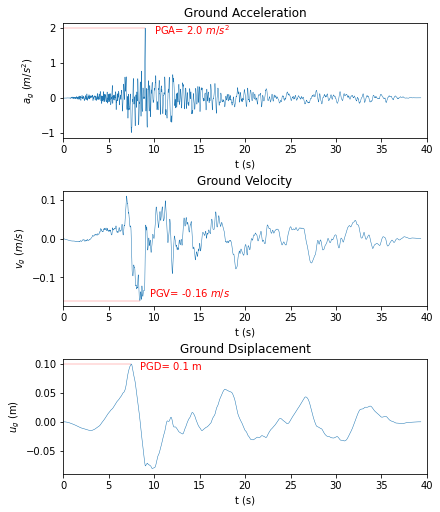

In [2]:
# Integrating acceleration to velocity
v_g = np.zeros(a_g.shape)
for i_step in range(v_g.shape[0]):
    v_g[i_step] = np.trapz(a_g[0:i_step],dx=dt)
    
# Integrating velocity to displacement
u_g = np.zeros(a_g.shape)
for i_step in range(u_g.shape[0]):
    u_g[i_step] = np.trapz(v_g[0:i_step],dx=dt)
    
# Computing Peak Ground Acceleration
pga_idx = np.argmax(np.abs(a_g))
pga = a_g[pga_idx]
# Computing Peak Ground Velocity
pgv_idx = np.argmax(np.abs(v_g))
pgv = v_g[pgv_idx]
# Computing Peak Ground Displacement
pgd_idx = np.argmax(np.abs(u_g))
pgd = u_g[pgd_idx]

# Plotting acceleration, velocity and displacement    
plt.figure(figsize=(6.00, 7.00),constrained_layout=True)
plt.subplot(3,1,1)
plt.plot(t,a_g,lw=0.5)
plt.hlines(y=pga, xmin=0, xmax=t[pga_idx], color='red',lw=0.25)
plt.text(x=t[pga_idx]+1, y=pga-0.20, s='PGA= '+str(np.around(pga,2))+' $m/s^{2}$', fontsize=10,color='red')
plt.title('Ground Acceleration')
plt.ylabel('$a_{g}$ ($m/s^{2}$)')
plt.xlabel('t (s)')
plt.xlim([0,40])

plt.subplot(3,1,2)
plt.plot(t,v_g,lw=0.5)
# plt.plot(t,v_gf,lw=0.5)
plt.hlines(y=pgv, xmin=0, xmax=t[pgv_idx], color='red',lw=0.25)
plt.text(x=t[pgv_idx]+1, y=pgv+0.01, s='PGV= '+str(np.around(pgv,2))+' $m/s$', fontsize=10,color='red')
plt.title('Ground Velocity')
plt.ylabel('$v_{g}$ ($m/s$)')
plt.xlabel('t (s)')
plt.xlim([0,40])

plt.subplot(3,1,3)
plt.plot(t,u_g,lw=0.5,label='unfiltered')
plt.hlines(y=pgd, xmin=0, xmax=t[pgd_idx], color='red',lw=0.25)
plt.text(x=t[pgd_idx]+1, y=pgd-0.01, s='PGD= '+str(np.around(pgd,2)) +' m', fontsize=10,color='red')
plt.title('Ground Dsiplacement')
plt.ylabel('$u_{g}$ (m)')
plt.xlabel('t (s)')
plt.xlim([0,40])

### Part 2 Fourier amplitude spectrum
The fast fourier transform is used to obtain the acceleration in frequency domain.

(0.0, 20.0)

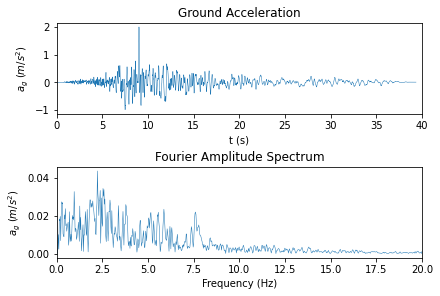

In [3]:
# Computing the Fourier Amplitude spectrum
A_g = (2.0/len(a_g))*np.fft.rfft(a_g)
freq_axis = np.fft.rfftfreq(a_g.shape[0],dt)

# Plotting ground acceleration in time and frequency domains
plt.figure(figsize=(6.00, 4.00),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(t,a_g,lw=0.5)
plt.title('Ground Acceleration')
plt.ylabel('$a_{g}$ ($m/s^{2}$)')
plt.xlabel('t (s)')
plt.xlim([0,40])

plt.subplot(2,1,2)
plt.plot(freq_axis,np.abs(A_g),lw=0.5)
plt.title('Fourier Amplitude Spectrum')
plt.ylabel('$a_{g}$ ($m/s^{2}$)')
plt.xlabel('Frequency (Hz)')
plt.xlim([0,20])

### Part 3 Acceleration response spectrum
The following time integration following Newmark algorithm for linear analysis is used.

In [4]:
def Newmark_linear(M,K,C,p,u_0,du_0,t_tot,h,gamma,beta):
    """
    Linear Newmark algorithm for implicit time integration of a SDOF
    
    INPUT:
        M       - Mass (kg)
        K       - Stiffness (N/m)
        C       - Damping (N s/m)
        p       - External load defined as a lambda function (N)
        u_0     - Initial displacement (m)
        du_0    - Initial velocity (m/s)
        t_tot   - Total analysis time (s)
        h       - time step (s)
        gamma   - Newmark coefficient, normally 1/2
        beta    - Newmark coefficient, normally 1/4
    
    OUTPUT:
        t       - Analysis time vector (s)
        u       - Displacement vector (m), len(t)
        du      - Velocity vector (m/s), len(t)
        d2u       - Acceleration vector (m/s2), len(t)
    
    """
    t = np.arange(0,t_tot+h,h)
    u = np.zeros((len(t),1))
    du = np.zeros((len(t),1))
    d2u = np.zeros((len(t),1))
    f = p
    
    u[0] = u_0
    du[0] = du_0
    
    M_star = M + gamma*h*C + beta*h*h*K
    d2u[0] = (1/M)*(f[0] - C*du[0] - K*u[0])
    
    for i in range(len(t)-1):
        du[i+1] = du[i] + (1-gamma)*h*d2u[i]
        u[i+1] = u[i] + h*du[i] + (0.5-beta)*h*h*d2u[i]
        
        d2u[i+1] = (1/M_star)*(f[i+1] - C*du[i+1] - K*u[i+1])
        du[i+1] = du[i+1] + (gamma)*h*d2u[i+1]
        u[i+1] = u[i+1] + (beta)*h*h*d2u[i+1]
    return u,du,d2u,t

A SDOF, with a given natural period, is subjected to ground displacement with acceleration equal to the given record of Imperial valley. Then, the peak displacement of this SDOF is obtained and multiplied by the square of its natural circular frequency to compute its maximum acceleration. This procedure is repeated for SDOFs with varying natural periods in the range of 0 to 5 seconds, saving their maximum acceleration. The plot showing the relationship between maximum acceleration vis natural period is our elastic response spectrum.

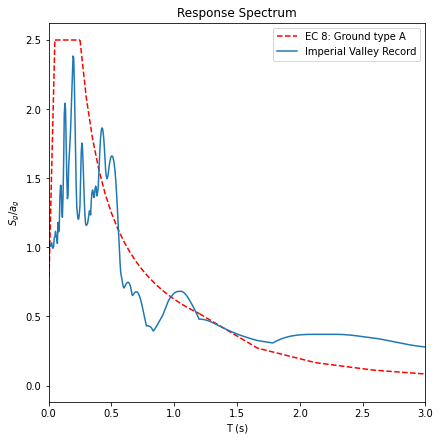

In [5]:
T = np.linspace(0.01,5,1000)
xi = 0.05
response = np.zeros(T.shape[0])
for i_T in range(T.shape[0]):
    w = 2*np.pi/T[i_T]
    m = 1
    k = m*(w**2)
    c = 2*xi*w*m
    p = -a_g/(pga)*m
    
    [u,_,_,_] = Newmark_linear(m,k,c,p,0,0,t[-2],dt,0.5,0.25)
    Sd = np.max(np.abs(u))
    response[i_T] = Sd*(w**2)

# EC 8 Response Spectrum
q = 1.0
T_spectrum = [0,0.05,0.25,1.2,10]       # Spectrum Parameters for A-type soil
S_0 = 1.0                               # Spectrum Parameters for A-type soil
resp_spectrum = [lambda t: S_0*(2/3 + (t/T_spectrum[1])*(2.5/q - 2/3)),
                  lambda t: S_0*(2.5/q) if (isinstance(t, float)) else S_0*(2.5/q)*np.ones(len(t)),
                  lambda t: S_0*(2.5/q)*(T_spectrum[2]/t),
                  lambda t: S_0*(2.5/q)*((T_spectrum[2]*T_spectrum[3])/(t**2))]

# Plotting response spectrum
plt.figure(figsize=(6.00, 6.00),constrained_layout=True)
for i_curve in range(len(resp_spectrum)):
    x = np.linspace(T_spectrum[i_curve],T_spectrum[i_curve+1],20,endpoint=True)
    S_norm = resp_spectrum[i_curve](x)
    if i_curve == 0: plt.plot(x,S_norm,'--',color='red',label='EC 8: Ground type A')
    else: plt.plot(x,S_norm,'--',color='red')
      
plt.plot(T,response,label='Imperial Valley Record')
plt.title('Response Spectrum')
plt.ylabel('$S_{g}/a_{g}$')
plt.xlabel('T (s)')
plt.xlim([0,3])
plt.legend()

### Part 4 RMS acceleration and Arias intensity

In [6]:
# RMS_acceleration and Arias intensity
a_g_RMS = np.sqrt(np.trapz(a_g**2,dx=dt)/t[-1]) #m/s2
I_a = (np.pi/(2*9.81))*np.trapz(a_g**2,dx=dt) #m/s

print('The RMS acceleration is')
print(str(np.around(a_g_RMS,2)) + ' m/s2')
print( )
print('The arias intensity is')
print(str(np.around(I_a,2)) + ' m/s')

The RMS acceleration is
0.19 m/s2

The arias intensity is
0.22 m/s


### Part 5 PGA for the same earthquake at a distance 40 km from epicenter

To estimate PGA for R= 40 km, it is most appropriate (because of location of earthquake) to use the attenuation relationship of Boore (1993). Use R= 10 and PHA(g)= 0.2 to compute the earthquake magnitude in Eq. 3.26. Then use the same equation with R = 40 km to estimate PHA. 
Or simply use Fig 3.22(b) and the curve for M = 6.5 (since it gives PGA= 0.2 g at R= 10 km) to read PGA= 0.1 g at R= 40 km

The figure below (available in Kramer figure 3.22(b)), showing the relationship between acceleration and distance to epicenter from Boore et al. (1993), is used because of the location of the earthquake. The curve corresponding to M = 6.5 is selected since it yields a PGA of 0.2 g for 10 km. This curve would give out a result of approximately 0.1 g for 40 km.

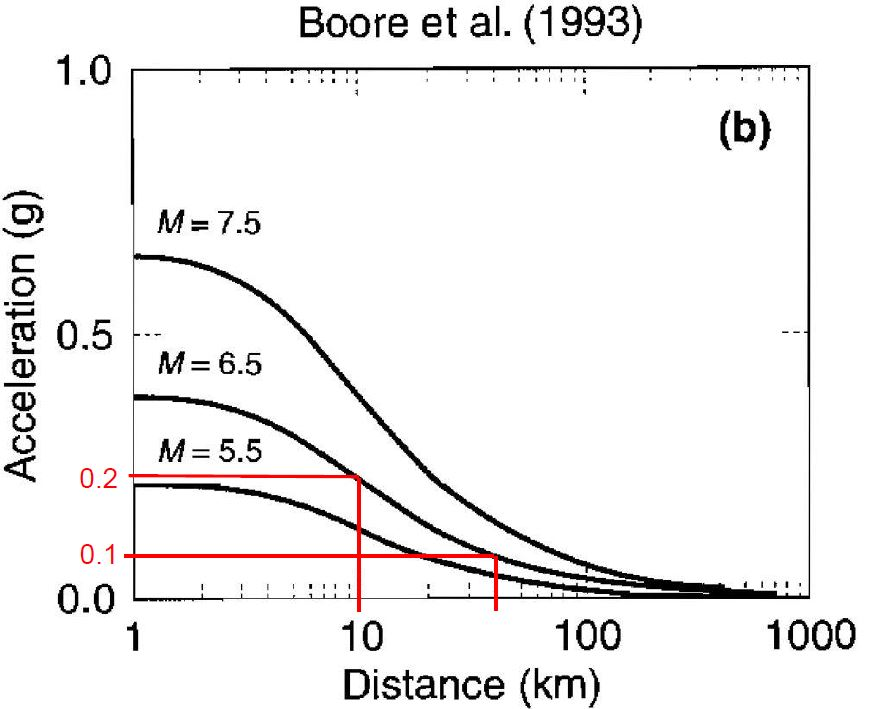